In [343]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from typing import List
from venn_abers import VennAbers
from sklearn.utils.validation import check_is_fitted
import warnings

In [344]:
# Suprimir o aviso específico
warnings.filterwarnings("ignore", category=RuntimeWarning, module="venn_abers")

In [345]:
# Gerar um conjunto de dados de classificação
X, y = make_classification(n_samples=100000, n_features=4, random_state=42)

In [346]:
# Dividir os dados em conjuntos de treinamento, calibração e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [347]:
class WrapperOOBBinaryConformalClassifier():
    """
    A conformal classifier based on Out-of-Bag (OOB) methodology, utilizing a random forest classifier as the underlying learner. 
    This class is inspired by the WrapperClassifier classes from the Crepes library.
    """

    def __init__(self, learner: RandomForestClassifier):
        """
        Constructs the classifier with a specified learner and a Venn-Abers calibration layer.

        Parameters:
        learner: RandomForestClassifier
            The base learner to be used in the classifier.

        Attributes:
        learner: RandomForestClassifier
            The base learner employed in the classifier.
        calibration_layer: VennAbers
            The calibration layer utilized in the classifier.
        feature_importances_: array-like of shape (n_features,)
            The feature importances derived from the learner.
        margin: array-like of shape (n_samples,), default=None
            Nonconformity measure based at the difference between the predicted probability
            of most likely incorrent class label and the predicted probability of the true label.
            Close to zero or negative margin indicates confidence in the true class label, while a large positive margin signals 
            confidence in an incorrect class, suggesting unreliable predictions. The mergin measures the risk level of the model's prediction.
        alpha: float, default=0.05
            The significance level applied in the classifier.
        """

        # Ensure the learner is fitted
        check_is_fitted(learner)

        # Initialize attributes
        self.learner = learner
        self.calibration_layer = VennAbers()
        self.feature_importances_ = self.learner.feature_importances_
        self.margin = None
        self.alpha = 0.05
        self.n = None

    def fit(self, y):
        """
        Fits the classifier to the training data. Calculates the conformity score for each training instance.

        Parameters:
        y: array-like of shape (n_samples,)
            The true labels.

        Returns:
        self: object
            Returns self.

        The function works as follows:
        - It first gets the out-of-bag probability predictions from the learner.
        - It then fits the calibration layer to these predictions and the true labels.
        - It computes the probability for each instance.
        - It finally turns these probabilities into non-conformity measure.
        """

        # Get the probability predictions
        y_prob = self.learner.oob_decision_function_

        self.calibration_layer.fit(y_prob, y)
        y_prob, _ = self.calibration_layer.predict_proba(y_prob)
        # We only need the probability for the true class
        self.n = len(self.learner.oob_decision_function_)
        
        self.margin = y_prob[np.arange(len(y_prob)), 1 - y] - y_prob[np.arange(len(y_prob)), y]

        return self
    
    def predict_proba(self, X):
        """
        This function predicts the class probabilities for the instances in X.
        
        Parameters:
        X: array-like of shape (n_samples, n_features)
            The input samples.

        Returns:
        p_prime: array-like of shape (n_samples, n_classes)
            The calibrated class probabilities.
        """

        y_score = self.learner.predict_proba(X)
        p_prime, _ = self.calibration_layer.predict_proba(y_score)
        return p_prime

    def predict(self, X):
        """
        This function predicts the classes for the instances in X.
        
        Parameters:
        X: array-like of shape (n_samples, n_features)
            The input samples.

        Returns:
        predictions: array-like of shape (n_samples,)
            The predicted classes. A class is predicted if its probability is greater than or equal to 0.50.
        """

        return (self.predict_proba(X)[:, 1] >= 0.50).astype(int)
    
    def predict_set(self, X, alpha=None):
        """
        This function predicts the possible set of classes for the instances in X based on the predefined significance level.
        
        Parameters:
        X: array-like of shape (n_samples, n_features)
            The input samples.
        alpha: float, default=None
            The significance level. If None, the value of self.alpha is used.

        Returns:
        prediction_set: array-like of shape (n_samples, n_classes)
            The predicted set of classes. A class is included in the set if its non-conformity score is less 
            than or equal to the quantile of the hinge loss distribution at the (n+1)*(1-alpha)/n level.
        """

        if alpha is None:
            alpha = self.alpha
        
        y_prob = self.predict_proba(X)
        class_0_prob = np.ravel(y_prob[:, [0]])
        class_1_prob = np.ravel(y_prob[:, [1]])
        nc_score = np.column_stack((class_1_prob - class_0_prob, class_0_prob - class_1_prob))

        q_level = np.ceil((self.n+1)*(1-alpha))/self.n
        qhat = np.quantile(self.margin, q_level, method='higher')

        return (nc_score <= qhat).astype(int)
    
    def _expected_calibration_error(self, y, y_prob, M=5):
        """
        This function calculates the expected calibration error (ECE) of the classifier.
        
        Parameters:
        y: array-like of shape (n_samples,)
            The true labels.
        y_prob: array-like of shape (n_samples, n_classes)
            The predicted probabilities.
        M: int, default=5
            The number of bins for the uniform binning approach.

        Returns:
        ece: float
            The expected calibration error.

        The function works as follows:
        - It first creates M bins with uniform width over the interval [0, 1].
        - For each sample, it computes the maximum predicted probability and makes a prediction.
        - It then checks whether each prediction is correct or not.
        - For each bin, it calculates the empirical probability of a sample falling into the bin.
        - If the empirical probability is greater than 0, it computes the accuracy and average confidence of the bin.
        - It then calculates the absolute difference between the accuracy and the average confidence, multiplies it by the empirical probability, and adds it to the total ECE.
        """
            
        # uniform binning approach with M number of bins
        bin_boundaries = np.linspace(0, 1, M + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        # get max probability per sample i
        confidences = np.max(y_prob, axis=1)
        # get predictions from confidences (positional in this case)
        predicted_label = np.argmax(y_prob, axis=1)

        # get a boolean list of correct/false predictions
        predictions = predicted_label==y

        ece = 0.0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # determine if sample is in bin m (between bin lower & upper)
            in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
            # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
            prob_in_bin = np.mean(in_bin)

            if prob_in_bin > 0:
                # get the accuracy of bin m: acc(Bm)
                avg_pred = np.mean(predictions[in_bin])
                # get the average confidence of bin m: conf(Bm)
                avg_confidence_in_bin = np.mean(confidences[in_bin])
                # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
                ece += np.abs(avg_pred - avg_confidence_in_bin) * prob_in_bin
        return ece
    
    def _empirical_coverage(self, X, alpha=None, iterations=100):
        """
        This function calculates the empirical coverage of the classifier.

        Parameters:
        X: array-like of shape (n_samples, n_features)
            The input samples.
        alpha: float, default=None
            The significance level. If None, the value of self.alpha is used.
        iterations: int, default=100
            The number of iterations for the empirical coverage calculation.

        Returns:
        average_coverage: float
            The average coverage over the iterations. It should be close to 1-alpha.
        """

        if alpha is None:
            alpha = self.alpha
            
        coverages = np.zeros((iterations,))
        y_prob = self.predict_proba(X)
        class_0_prob = np.ravel(y_prob[:, [0]])
        class_1_prob = np.ravel(y_prob[:, [1]])
        scores = np.column_stack((class_1_prob - class_0_prob, class_0_prob - class_1_prob))
        n = int(len(scores) * 0.20)

        for i in range(iterations):
            np.random.shuffle(scores) # shuffle
            calib_scores, val_scores = (scores[:n],scores[n:]) # split
            q_level = np.ceil((n + 1) * (1 - alpha))/n
            qhat = np.quantile(calib_scores, q_level, method='higher') # calibrate
            coverages[i] = (val_scores <= qhat).astype(float).mean() # see caption
            average_coverage = coverages.mean() # should be close to 1-alpha

        return average_coverage

    def calibrate_alpha(self, X):
        """
        This function calibrates the alpha level of the classifier based on the calibration set. The alpha level is a threshold that determines the size of the prediction set. 
        A smaller alpha results in a larger prediction set and vice versa.

        A lower validity (AvgC) value signifies that the model is better at producing more specific and informative
        predictions. 

        A higher efficiency (OneC) value indicates that the conformal prediction model produces specific and informative
        predictions more efficiently. 

        Researchers have determined that the most effective approach is to use a margin-based nonconformity
        function to achieve a high rate of singleton predictions (OneC).

        Parameters:
        X: array-like of shape (n_samples, n_features)
            The calibration input samples. These are typically a subset of the training data.

        Returns:
        self: object
            Returns self.

        The function works as follows:
        - It first initializes a dictionary with potential alpha values of 0.15, 0.10, and 0.05.
        - For each potential alpha, it computes the prediction set for the calibration data.
        - It then calculates the proportion of instances in the calibration set where the prediction set contains exactly one class.
        - The alpha that results in the highest proportion of single-class prediction sets is selected as the calibrated alpha for the classifier.
        """

        alphas = {k: None for k in [0.15, 0.10, 0.05]}

        for alpha in alphas:
            predict_set = self.predict_set(X, alpha)
            alphas[alpha] = np.sum([np.sum(p) == 1 for p in predict_set]) / len(predict_set)#OneC

        self.alpha = max(alphas, key=alphas.get)

        return self
    
    def evaluate(self, X, y, alpha=None):
        """
        This function evaluates the performance of the conformal classifier on the given test data and labels.
        
        Parameters:
        X: array-like of shape (n_samples, n_features)
            The test input samples.
        y: array-like of shape (n_samples,)
            The true labels for X.
        alpha: float, default=None
            The significance level. If None, the value of self.alpha is used.

        Returns:
        results: dict
            A dictionary with the following keys and their corresponding values:
            - "one_c": The proportion of instances where the prediction set contains exactly one class.
            - "avg_c": The average size of the prediction set.
            - "empty": The proportion of instances where the prediction set is empty.
            - "error": The error rate, i.e., the proportion of instances where the true label is not in the prediction set.
            - "log_loss": The log loss.
            - "brier_loss": The Brier score loss.
            - "ece": The expected calibration error.
            - "empirical_coverage": The empirical coverage.
        """

        if alpha is None:
            alpha = self.alpha

        results = {}
        y_prob = self.predict_proba(X)
        predict_set = self.predict_set(X, alpha)
        n_digits = 3
        results["one_c"] = round(np.sum([np.sum(p) == 1 for p in predict_set]) / len(y), n_digits)
        results["avg_c"] = round(np.sum(predict_set) / len(predict_set), n_digits)
        results["empty"] = round(np.sum([np.sum(p) == 0 for p in predict_set]) / len(y), n_digits)
        results["error"] = round(1-np.sum(predict_set[np.arange(len(y)), y]) / len(y), n_digits)
        results["log_loss"] = round(log_loss(y, y_prob[:,1]), n_digits)
        results["brier_loss"] = round(brier_score_loss(y, y_prob[:,1]), n_digits)
        results["ece"] = round(self._expected_calibration_error(y, y_prob), n_digits)
        results["empirical_coverage"] = round(self._empirical_coverage(X, alpha), n_digits)

        return results

    

In [348]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
clf = WrapperOOBConformalClassifier(rf)
clf.fit(y_train)

Avaliar o melhor nível de confiança com menor taxa de erro

In [349]:
# Create a DataFrame from the data
def plot_onec_avgc(clf: WrapperOOBConformalClassifier, X: np.ndarray, fig_type=None):
    
    def custom_legend(fig, nameSwap):
        for i, dat in enumerate(fig.data):
            for elem in dat:
                if elem == "name":
                    fig.data[i].name = nameSwap[fig.data[i].name]
        return fig
    
    def get_error_metrics(clf: WrapperOOBConformalClassifier, X: np.ndarray) -> List:
        error_rate = {k: {} for k in [0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10, 0.05]}
        for error in error_rate:
            predict_set = clf.predict_set(X, alpha = error)
            error_rate[error]["efficiency"] = np.sum([np.sum(p) == 1 for p in predict_set]) / len(predict_set)
            error_rate[error]["validity"] = np.sum(predict_set) / len(predict_set)
        return error_rate

    error_rate = get_error_metrics(clf, X)

    df = pd.DataFrame(error_rate).T

    # Create the bar chart
    fig = px.line(df, x=df.index, y=['efficiency', 'validity'],
                labels={'value': 'Escore'},
                markers=True,
                title='Relacao Eficiencia & Solidez versus Taxa de Erro',
                color_discrete_sequence=['darkblue', 'orange'],
                width=800,
                height=400)
    fig.update_layout(hovermode="x")
    fig.update_traces(hovertemplate="%{y}")
    custom_legend(
            fig=fig, nameSwap={"efficiency": "Eficiencia", "validity": "Solidez"}
        )
    fig.update_layout(legend=dict(
        title="Metrica"))
    fig.update_yaxes(title_text="Escore")
    fig.update_xaxes(title_text="Taxa de Erro")
    return fig.show(fig_type)

In [350]:
def plot_roc_curve(clf: WrapperOOBConformalClassifier, X, y, fig_type=None):

    y_prob = clf.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)

    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    return fig.show(fig_type)

def calibration_plot(clf, X, y, fig_type=None) -> go.Figure:
    y_prob = clf.predict_proba(X)
    v_prob_true, v_prob_pred = calibration_curve(y, y_prob[:, 1], n_bins=10)

    fig = go.Figure()

    # Add traces for each model

    fig.add_trace(go.Scatter(x=v_prob_pred, y=v_prob_true, mode='lines+markers', name="RandomForest"))

    # Add a trace for the perfectly calibrated line
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Perfectly calibrated', line=dict(dash='dash', color='grey')))
    
    fig.update_layout(
        title="Calibration Plot",
        xaxis_title="Mean predicted probability",
        yaxis_title="Fraction of positives",
        legend_title="Modelos",
        autosize=False,
    )

    return fig.show(fig_type)

def nc_score_histogram(clf, X, y, fig_type=None):
    y_prob = clf.predict_proba(X)
    nc_score = y_prob[np.arange(len(y_prob)), 1 - y] - y_prob[np.arange(len(y_prob)), y]
    fig = px.histogram(nc_score, nbins=30, range_x=(0, 1), title="Histograma de Escora de NCScore")
    fig.update_layout(hovermode="x")
    fig.update_traces(hovertemplate="%{y}")
    fig.update_yaxes(title_text="Frequência")
    fig.update_xaxes(title_text="Escore de Não Conformidade")
    fig.update_layout(showlegend=False)
    return fig.show(fig_type)

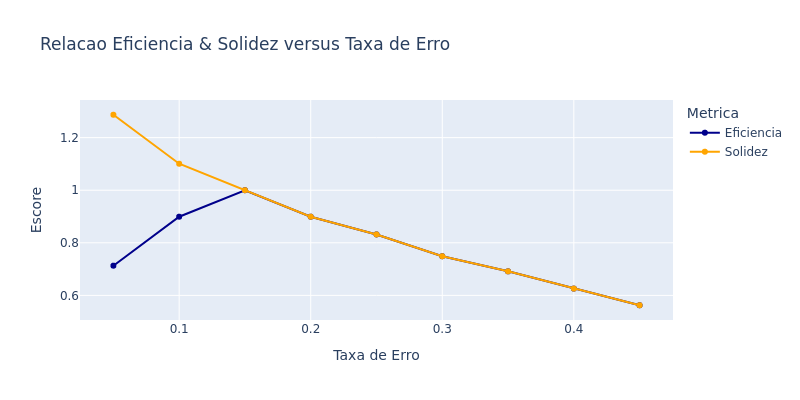

In [351]:
plot_onec_avgc(clf, X_calib, "png")

Melhor taxa de erro com a maior eficiência

In [352]:
clf.calibrate_alpha(X_calib)
clf.alpha

0.15

In [353]:
"""
A lower validity (AvgC) value signifies that the model is better at producing more specific and informative
predictions. 

A higher efficiency (OneC) value indicates that the conformal prediction model produces specific and informative
predictions more efficiently. 

Researchers have determined that the most effective approach is to use a margin-based nonconformity
function to achieve a high rate of singleton predictions (OneC).

"""


'\nA lower validity (AvgC) value signifies that the model is better at producing more specific and informative\npredictions. \n\nA higher efficiency (OneC) value indicates that the conformal prediction model produces specific and informative\npredictions more efficiently. \n\nResearchers have determined that the most effective approach is to use a margin-based nonconformity\nfunction to achieve a high rate of singleton predictions (OneC).\n\n'

In [354]:
#Outputs
#Não há confiança para nenhum dos labels. [0, 0]
#Há confiança de apenas um dos labels. [0, 1]; [1, 0]
#Há um grau de incerteza para que classe o dado de entrada teria. [1, 1]; [1, 1]

Modelo Aprendiz

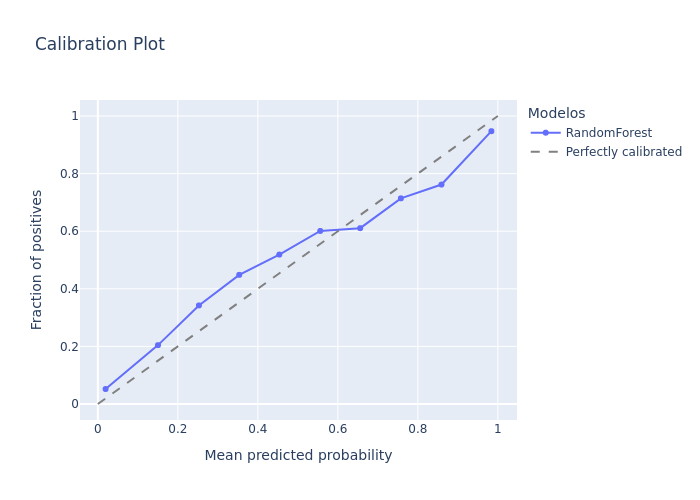

In [355]:
calibration_plot(clf.learner, X_test, y_test, "png")

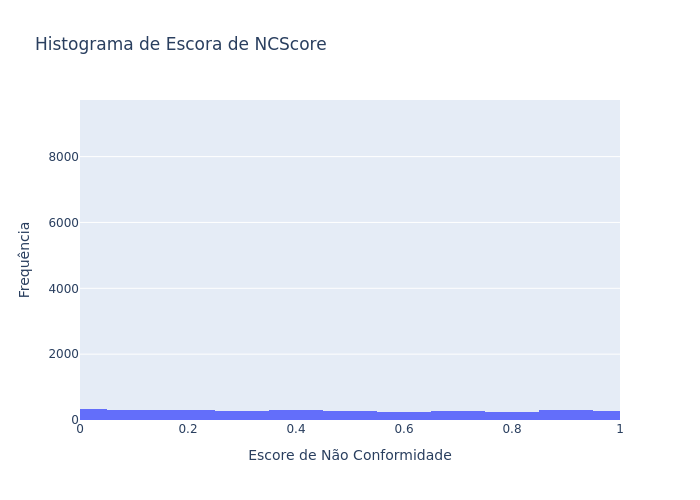

In [356]:
nc_score_histogram(clf.learner, X_test, y_test, "png")

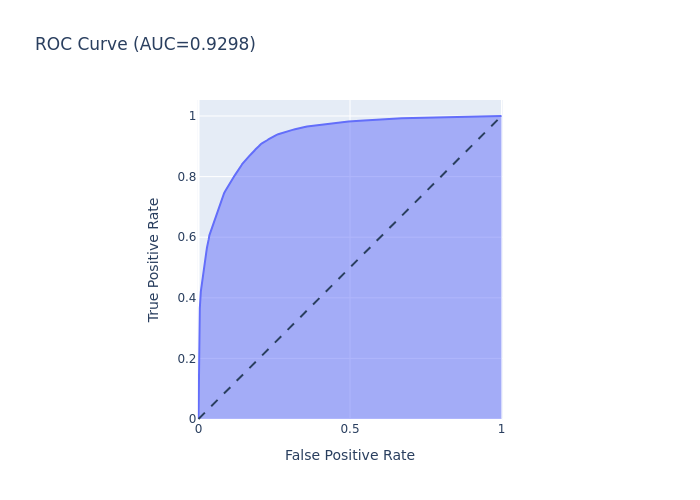

In [357]:
plot_roc_curve(clf.learner, X_test, y_test, "png")

Calibrador

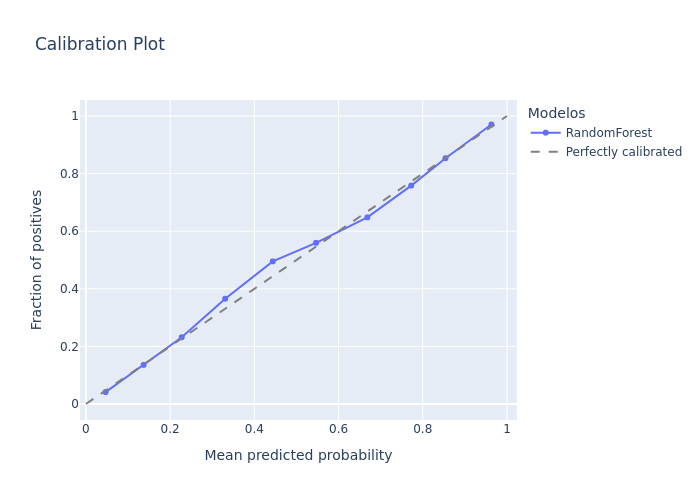

In [358]:
calibration_plot(clf, X_test, y_test, "png")

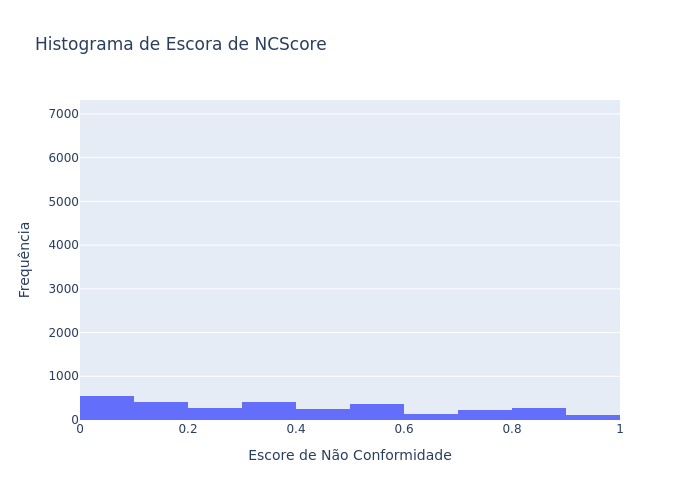

In [359]:
nc_score_histogram(clf, X_test, y_test, "png")

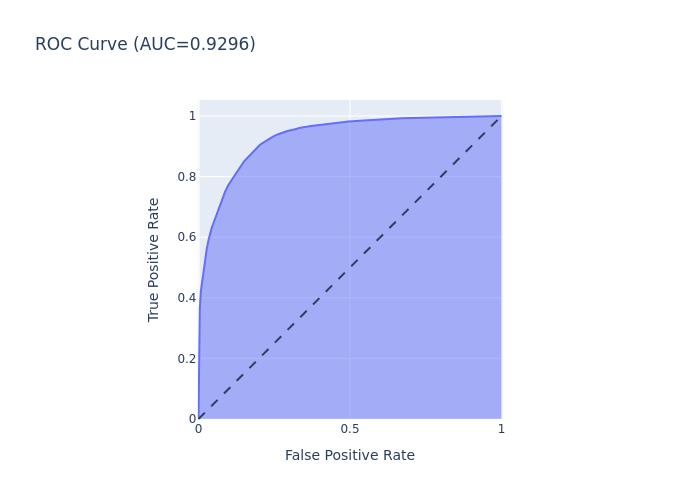

In [360]:
plot_roc_curve(clf, X_test, y_test, "png")

In [361]:
clf.evaluate(X_test, y_test)

{'one_c': 1.0,
 'avg_c': 1.0,
 'empty': 0.0,
 'error': 0.15,
 'log_loss': 0.336,
 'brier_loss': 0.105,
 'ece': 0.008,
 'empirical_coverage': 0.907}

In [362]:
clf.alpha

0.15

In [363]:
#É necessário mais testes!

In [364]:
"""
Margin, de crepes
# Número de linhas e colunas em y_prob
num_linhas = len(y_prob)
num_cols = y_prob.shape[1]

# Inicializando o resultado como uma lista vazia
resultado = []
# Iterando sobre cada linha em y_prob
for i in range(num_linhas):
    linha_resultado = []
    # Iterando sobre cada coluna em y_prob
    for c in range(num_cols):
        # Criando uma máscara booleana para todas as colunas que não são 'c'
        mascara = np.ones(num_cols, bool)
        mascara[c] = False
        # Calculando o valor para adicionar ao resultado
        valor = np.max(y_prob[i, mascara]) - y_prob[i, c]
        linha_resultado.append(valor)
    resultado.append(linha_resultado)
"""

"\nMargin, de crepes\n# Número de linhas e colunas em y_prob\nnum_linhas = len(y_prob)\nnum_cols = y_prob.shape[1]\n\n# Inicializando o resultado como uma lista vazia\nresultado = []\n# Iterando sobre cada linha em y_prob\nfor i in range(num_linhas):\n    linha_resultado = []\n    # Iterando sobre cada coluna em y_prob\n    for c in range(num_cols):\n        # Criando uma máscara booleana para todas as colunas que não são 'c'\n        mascara = np.ones(num_cols, bool)\n        mascara[c] = False\n        # Calculando o valor para adicionar ao resultado\n        valor = np.max(y_prob[i, mascara]) - y_prob[i, c]\n        linha_resultado.append(valor)\n    resultado.append(linha_resultado)\n"

In [365]:
"""
#QS1
#Margin NC Score para classificação binária
margin = y_prob[np.arange(len(y_prob)), 1 - y_test] - y_prob[np.arange(len(y_prob)), y_test]
#Margin NC Score sem uso de rótulo
class_0_prob = np.ravel(y_prob[:, [0]])
class_1_prob = np.ravel(y_prob[:, [1]])
margin = np.column_stack((class_1_prob - class_0_prob, class_0_prob - class_1_prob))
"""

In [367]:
#Para gerar a margem de dados sem classe (y_test), ver a diferença da maior probabilidade para cada rotulo

In [368]:
"""Close to zero or negative margin indicates confidence in the true class label, while a large positive margin signals 
confidence in an incorrect class, suggesting unreliable predictions. The mergin measures the risk level of the model's prediction."""

"Close to zero or negative margin indicates confidence in the true class label, while a large positive margin signals \nconfidence in an incorrect class, suggesting unreliable predictions. The mergin measures the risk level of the model's prediction."